# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [4]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

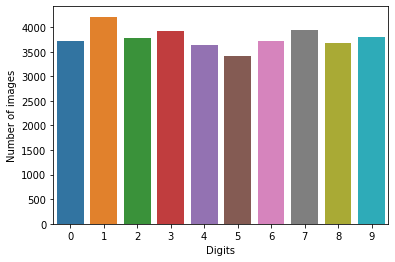

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

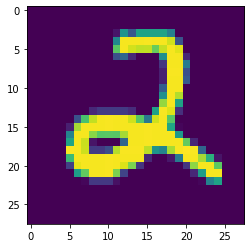

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

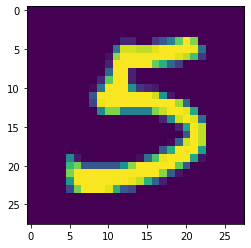

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [14]:
# we will save the model with this name
path_best_model = 'cnn_model_2.h5'

# starting point for the optimization
best_accuracy = 0

In [15]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # Note, with this configuration, we sample different filters, kernels
        # stride etc, for each convolutional layer that we add

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters_{}'.format(i), [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size{}'.format(i), [3, 5]),
            strides=trial.suggest_categorical('strides{}'.format(i), [1, 2]),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units{}'.format(i), 5, 512),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [16]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study_2"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [17]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2021-05-20 18:21:58,048] A new study created in RDB with name: cnn_study_2


Epoch 1/3
266/266 [==============================] - 39s 144ms/step - loss: 0.5335 - accuracy: 0.8488 - val_loss: 0.1405 - val_accuracy: 0.9590
Epoch 2/3
266/266 [==============================] - 36s 136ms/step - loss: 0.0888 - accuracy: 0.9710 - val_loss: 0.1039 - val_accuracy: 0.9720
Epoch 3/3
266/266 [==============================] - 30s 114ms/step - loss: 0.0468 - accuracy: 0.9851 - val_loss: 0.1000 - val_accuracy: 0.9733


[I 2021-05-20 18:23:45,091] Trial 0 finished with value: 0.9732804298400879 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'num_dense_layers': 1, 'units0': 389, 'optimizer_name': 'Adam', 'learning_rate': 0.005141375818387415}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 132s 487ms/step - loss: 1.4591 - accuracy: 0.6059 - val_loss: 0.2752 - val_accuracy: 0.9164
Epoch 2/3
266/266 [==============================] - 138s 520ms/step - loss: 0.2207 - accuracy: 0.9318 - val_loss: 0.2164 - val_accuracy: 0.9357
Epoch 3/3
266/266 [==============================] - 133s 499ms/step - loss: 0.1591 - accuracy: 0.9494 - val_loss: 0.2193 - val_accuracy: 0.9344


[I 2021-05-20 18:30:28,771] Trial 1 finished with value: 0.9343915581703186 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 64, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 353, 'units1': 297, 'optimizer_name': 'Adam', 'learning_rate': 0.006688787074386754}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 330s 1s/step - loss: 15.9149 - accuracy: 0.1087 - val_loss: 2.3023 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 326s 1s/step - loss: 2.3031 - accuracy: 0.1079 - val_loss: 2.3034 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 329s 1s/step - loss: 2.3028 - accuracy: 0.1108 - val_loss: 2.3046 - val_accuracy: 0.0960


[I 2021-05-20 18:46:56,234] Trial 2 finished with value: 0.09603174775838852 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 334, 'optimizer_name': 'RMSprop', 'learning_rate': 0.007158060825068953, 'momentum': 0.7288210488996536}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 278s 1s/step - loss: 3.8213 - accuracy: 0.1001 - val_loss: 3.1188 - val_accuracy: 0.1079
Epoch 2/3
266/266 [==============================] - 278s 1s/step - loss: 2.6303 - accuracy: 0.1038 - val_loss: 3.9200 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 259s 976ms/step - loss: 2.8060 - accuracy: 0.1006 - val_loss: 2.9851 - val_accuracy: 0.1037


[I 2021-05-20 19:00:32,491] Trial 3 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 24, 'units1': 441, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00965484036942336, 'momentum': 0.46253966715483774}. Best is trial 0 with value: 0.9732804298400879.


Epoch 1/3
266/266 [==============================] - 160s 595ms/step - loss: 0.9944 - accuracy: 0.7624 - val_loss: 0.1286 - val_accuracy: 0.9614
Epoch 2/3
266/266 [==============================] - 140s 528ms/step - loss: 0.0980 - accuracy: 0.9722 - val_loss: 0.1152 - val_accuracy: 0.9693
Epoch 3/3
266/266 [==============================] - 157s 589ms/step - loss: 0.0650 - accuracy: 0.9817 - val_loss: 0.0926 - val_accuracy: 0.9765


[I 2021-05-20 19:08:10,412] Trial 4 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'num_dense_layers': 1, 'units0': 255, 'optimizer_name': 'RMSprop', 'learning_rate': 0.008853217919545443, 'momentum': 0.17963032837491807}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 14s 46ms/step - loss: 2.0599 - accuracy: 0.5772 - val_loss: 0.1980 - val_accuracy: 0.9402
Epoch 2/3
266/266 [==============================] - 11s 43ms/step - loss: 0.1562 - accuracy: 0.9547 - val_loss: 0.1951 - val_accuracy: 0.9566
Epoch 3/3
266/266 [==============================] - 10s 36ms/step - loss: 0.1074 - accuracy: 0.9706 - val_loss: 0.1643 - val_accuracy: 0.9653


[I 2021-05-20 19:08:46,372] Trial 5 finished with value: 0.9653438925743103 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'num_dense_layers': 2, 'units0': 286, 'units1': 192, 'activation1': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.008840779453710527, 'momentum': 0.14435937843393642}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 43s 151ms/step - loss: 0.4753 - accuracy: 0.8437 - val_loss: 0.1221 - val_accuracy: 0.9646
Epoch 2/3
266/266 [==============================] - 40s 149ms/step - loss: 0.0984 - accuracy: 0.9691 - val_loss: 0.1237 - val_accuracy: 0.9616
Epoch 3/3
266/266 [==============================] - 39s 147ms/step - loss: 0.0881 - accuracy: 0.9719 - val_loss: 0.1636 - val_accuracy: 0.9500


[I 2021-05-20 19:10:50,072] Trial 6 finished with value: 0.949999988079071 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 152, 'optimizer_name': 'Adam', 'learning_rate': 0.009013413254775211}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 107s 394ms/step - loss: 2.4334 - accuracy: 0.1073 - val_loss: 2.3023 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 117s 440ms/step - loss: 2.3030 - accuracy: 0.1081 - val_loss: 2.3032 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 118s 444ms/step - loss: 2.3026 - accuracy: 0.1104 - val_loss: 2.3042 - val_accuracy: 0.0960


[I 2021-05-20 19:16:33,546] Trial 7 finished with value: 0.09603174775838852 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'relu', 'num_dense_layers': 1, 'units0': 239, 'optimizer_name': 'RMSprop', 'learning_rate': 0.006119554297468513, 'momentum': 0.7533193443015165}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 46s 164ms/step - loss: 0.9413 - accuracy: 0.7100 - val_loss: 0.2274 - val_accuracy: 0.9339
Epoch 2/3
266/266 [==============================] - 40s 152ms/step - loss: 0.1918 - accuracy: 0.9406 - val_loss: 0.1696 - val_accuracy: 0.9519
Epoch 3/3
266/266 [==============================] - 45s 171ms/step - loss: 0.1095 - accuracy: 0.9638 - val_loss: 0.1211 - val_accuracy: 0.9635


[I 2021-05-20 19:18:46,460] Trial 8 finished with value: 0.9634920358657837 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 3, 'units0': 242, 'units1': 236, 'units2': 319, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0002461643466692788, 'momentum': 0.18819892384189763}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 194s 716ms/step - loss: 0.4790 - accuracy: 0.8544 - val_loss: 0.1363 - val_accuracy: 0.9619
Epoch 2/3
266/266 [==============================] - 181s 679ms/step - loss: 0.1077 - accuracy: 0.9683 - val_loss: 0.1090 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 184s 692ms/step - loss: 0.0924 - accuracy: 0.9703 - val_loss: 0.1306 - val_accuracy: 0.9606


[I 2021-05-20 19:28:06,938] Trial 9 finished with value: 0.9605820178985596 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 1, 'units0': 72, 'optimizer_name': 'Adam', 'learning_rate': 0.0059181104466350535}. Best is trial 4 with value: 0.97645503282547.


Epoch 1/3
266/266 [==============================] - 36s 123ms/step - loss: 0.8766 - accuracy: 0.6965 - val_loss: 0.0956 - val_accuracy: 0.9714
Epoch 2/3
266/266 [==============================] - 32s 121ms/step - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.0715 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 33s 125ms/step - loss: 0.0478 - accuracy: 0.9856 - val_loss: 0.0789 - val_accuracy: 0.9799


[I 2021-05-20 19:29:49,611] Trial 10 finished with value: 0.9798941612243652 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 473, 'units1': 12, 'activation1': 'relu', 'units2': 11, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.00266296121411845, 'momentum': 0.46432988966267597}. Best is trial 10 with value: 0.9798941612243652.


Epoch 1/3
266/266 [==============================] - 39s 135ms/step - loss: 0.8934 - accuracy: 0.6795 - val_loss: 0.1433 - val_accuracy: 0.9616
Epoch 2/3
266/266 [==============================] - 32s 119ms/step - loss: 0.0858 - accuracy: 0.9747 - val_loss: 0.0744 - val_accuracy: 0.9802
Epoch 3/3
266/266 [==============================] - 38s 142ms/step - loss: 0.0506 - accuracy: 0.9844 - val_loss: 0.0712 - val_accuracy: 0.9812


[I 2021-05-20 19:31:40,207] Trial 11 finished with value: 0.9812169075012207 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 495, 'units1': 11, 'activation1': 'relu', 'units2': 20, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0026108673783509046, 'momentum': 0.4363176998524363}. Best is trial 11 with value: 0.9812169075012207.


Epoch 1/3
266/266 [==============================] - 40s 139ms/step - loss: 1.0620 - accuracy: 0.6063 - val_loss: 0.0927 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 34s 130ms/step - loss: 0.0787 - accuracy: 0.9756 - val_loss: 0.0777 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 36s 135ms/step - loss: 0.0461 - accuracy: 0.9858 - val_loss: 0.0605 - val_accuracy: 0.9833


[I 2021-05-20 19:33:35,474] Trial 12 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 492, 'units1': 12, 'activation1': 'relu', 'units2': 17, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0022406478015239675, 'momentum': 0.44436701977005505}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 39s 136ms/step - loss: 2.3024 - accuracy: 0.1112 - val_loss: 2.3014 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 34s 128ms/step - loss: 2.3015 - accuracy: 0.1078 - val_loss: 2.3008 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 33s 126ms/step - loss: 2.3011 - accuracy: 0.1133 - val_loss: 2.3013 - val_accuracy: 0.1146


[I 2021-05-20 19:35:23,960] Trial 13 finished with value: 0.11455026268959045 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 490, 'units1': 30, 'activation1': 'relu', 'units2': 6, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.002530026702391447, 'momentum': 0.35069250188205026}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 46s 153ms/step - loss: 0.5659 - accuracy: 0.8023 - val_loss: 0.0936 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 23s 87ms/step - loss: 0.0799 - accuracy: 0.9756 - val_loss: 0.0898 - val_accuracy: 0.9807
Epoch 3/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0534 - accuracy: 0.9845 - val_loss: 0.0862 - val_accuracy: 0.9802


[I 2021-05-20 19:36:49,954] Trial 14 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 511, 'units1': 89, 'activation1': 'relu', 'units2': 100, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0025632692193490996, 'momentum': 0.6203955760637716}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 18s 61ms/step - loss: 0.8192 - accuracy: 0.7555 - val_loss: 0.1437 - val_accuracy: 0.9577
Epoch 2/3
266/266 [==============================] - 13s 50ms/step - loss: 0.1219 - accuracy: 0.9634 - val_loss: 0.0904 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 19s 71ms/step - loss: 0.0720 - accuracy: 0.9779 - val_loss: 0.0756 - val_accuracy: 0.9783


[I 2021-05-20 19:37:41,140] Trial 15 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 426, 'units1': 125, 'activation1': 'relu', 'units2': 162, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.00033920633903364956, 'momentum': 0.36545400651270277}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 24s 81ms/step - loss: 2.3198 - accuracy: 0.1095 - val_loss: 2.3020 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 21s 78ms/step - loss: 2.3019 - accuracy: 0.1085 - val_loss: 2.3013 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 20s 77ms/step - loss: 2.3016 - accuracy: 0.1130 - val_loss: 2.3021 - val_accuracy: 0.1146


[I 2021-05-20 19:38:47,745] Trial 16 finished with value: 0.11455026268959045 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 512, 'units1': 5, 'activation1': 'relu', 'units2': 453, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0037385944284192623, 'momentum': 0.5925387072087202}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 30s 103ms/step - loss: 0.6419 - accuracy: 0.7787 - val_loss: 0.1273 - val_accuracy: 0.9601
Epoch 2/3
266/266 [==============================] - 24s 91ms/step - loss: 0.0733 - accuracy: 0.9773 - val_loss: 0.0718 - val_accuracy: 0.9794
Epoch 3/3
266/266 [==============================] - 17s 65ms/step - loss: 0.0484 - accuracy: 0.9834 - val_loss: 0.0696 - val_accuracy: 0.9833


[I 2021-05-20 19:40:00,164] Trial 17 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 438, 'units1': 361, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0015754677956798648, 'momentum': 0.32212559844402117}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 75ms/step - loss: 0.6547 - accuracy: 0.7769 - val_loss: 0.1013 - val_accuracy: 0.9659
Epoch 2/3
266/266 [==============================] - 17s 64ms/step - loss: 0.0836 - accuracy: 0.9745 - val_loss: 0.0715 - val_accuracy: 0.9799
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.0657 - val_accuracy: 0.9825


[I 2021-05-20 19:40:58,128] Trial 18 finished with value: 0.9825396537780762 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 429, 'units1': 371, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010183930139164455, 'momentum': 0.3366026137766247}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 21s 72ms/step - loss: 0.7040 - accuracy: 0.7696 - val_loss: 0.1044 - val_accuracy: 0.9683
Epoch 2/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0776 - accuracy: 0.9762 - val_loss: 0.0792 - val_accuracy: 0.9765
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0465 - accuracy: 0.9845 - val_loss: 0.0896 - val_accuracy: 0.9754


[I 2021-05-20 19:41:59,982] Trial 19 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 454, 'units1': 502, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0013990189028376516, 'momentum': 0.2456932707628172}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 29s 104ms/step - loss: 0.5612 - accuracy: 0.8096 - val_loss: 0.1072 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 27s 103ms/step - loss: 0.0864 - accuracy: 0.9730 - val_loss: 0.0785 - val_accuracy: 0.9775
Epoch 3/3
266/266 [==============================] - 26s 97ms/step - loss: 0.0529 - accuracy: 0.9832 - val_loss: 0.0710 - val_accuracy: 0.9802


[I 2021-05-20 19:43:22,987] Trial 20 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 365, 'units1': 347, 'optimizer_name': 'Adam', 'learning_rate': 0.004043506574357688}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 74ms/step - loss: 0.6677 - accuracy: 0.7735 - val_loss: 0.0939 - val_accuracy: 0.9704
Epoch 2/3
266/266 [==============================] - 18s 67ms/step - loss: 0.0816 - accuracy: 0.9734 - val_loss: 0.0787 - val_accuracy: 0.9762
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0503 - accuracy: 0.9833 - val_loss: 0.0806 - val_accuracy: 0.9799


[I 2021-05-20 19:44:21,787] Trial 21 finished with value: 0.9798941612243652 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 421, 'units1': 380, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0012142160592243192, 'momentum': 0.30285960276296225}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 75ms/step - loss: 0.5726 - accuracy: 0.8092 - val_loss: 0.1154 - val_accuracy: 0.9659
Epoch 2/3
266/266 [==============================] - 17s 66ms/step - loss: 0.0775 - accuracy: 0.9773 - val_loss: 0.0874 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0537 - accuracy: 0.9823 - val_loss: 0.0782 - val_accuracy: 0.9786


[I 2021-05-20 19:45:22,243] Trial 22 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 425, 'units1': 407, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0012777581333840336, 'momentum': 0.5718739184449542}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 21s 71ms/step - loss: 1.9920 - accuracy: 0.4302 - val_loss: 0.7837 - val_accuracy: 0.7690
Epoch 2/3
266/266 [==============================] - 18s 66ms/step - loss: 0.6261 - accuracy: 0.8274 - val_loss: 0.4041 - val_accuracy: 0.8828
Epoch 3/3
266/266 [==============================] - 34s 127ms/step - loss: 0.3481 - accuracy: 0.8993 - val_loss: 0.2832 - val_accuracy: 0.9161


[I 2021-05-20 19:46:35,670] Trial 23 finished with value: 0.9161375761032104 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 310, 'units1': 316, 'optimizer_name': 'RMSprop', 'learning_rate': 5.246165136033043e-05, 'momentum': 0.28644870235279585}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 50s 174ms/step - loss: 0.6108 - accuracy: 0.7899 - val_loss: 0.0988 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 44s 165ms/step - loss: 0.0781 - accuracy: 0.9772 - val_loss: 0.0993 - val_accuracy: 0.9730
Epoch 3/3
266/266 [==============================] - 44s 167ms/step - loss: 0.0541 - accuracy: 0.9824 - val_loss: 0.0886 - val_accuracy: 0.9772


[I 2021-05-20 19:48:55,305] Trial 24 finished with value: 0.9772486686706543 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 392, 'units1': 454, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0017651664912190653, 'momentum': 0.34484967768252434}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 40s 132ms/step - loss: 0.7095 - accuracy: 0.7715 - val_loss: 0.1011 - val_accuracy: 0.9690
Epoch 2/3
266/266 [==============================] - 34s 127ms/step - loss: 0.0959 - accuracy: 0.9706 - val_loss: 0.1296 - val_accuracy: 0.9659
Epoch 3/3
266/266 [==============================] - 32s 121ms/step - loss: 0.0671 - accuracy: 0.9793 - val_loss: 0.1146 - val_accuracy: 0.9722


[I 2021-05-20 19:50:42,459] Trial 25 finished with value: 0.9722222089767456 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 451, 'units1': 273, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0037659996196933387, 'momentum': 0.3932583381933051}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 65s 229ms/step - loss: 0.8563 - accuracy: 0.7081 - val_loss: 0.1224 - val_accuracy: 0.9640
Epoch 2/3
266/266 [==============================] - 51s 193ms/step - loss: 0.1082 - accuracy: 0.9681 - val_loss: 0.0980 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 58s 218ms/step - loss: 0.0658 - accuracy: 0.9799 - val_loss: 0.0852 - val_accuracy: 0.9754


[I 2021-05-20 19:53:38,312] Trial 26 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 32, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 3, 'units0': 510, 'units1': 360, 'units2': 283, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007843290128324143, 'momentum': 0.2470896291688005}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 43s 145ms/step - loss: 0.5644 - accuracy: 0.8088 - val_loss: 0.1108 - val_accuracy: 0.9667
Epoch 2/3
266/266 [==============================] - 35s 131ms/step - loss: 0.0833 - accuracy: 0.9750 - val_loss: 0.0914 - val_accuracy: 0.9751
Epoch 3/3
266/266 [==============================] - 34s 129ms/step - loss: 0.0578 - accuracy: 0.9828 - val_loss: 0.1003 - val_accuracy: 0.9775


[I 2021-05-20 19:55:31,687] Trial 27 finished with value: 0.9775132536888123 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 188, 'units1': 473, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001971584235483052, 'momentum': 0.5485776970569619}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 45s 157ms/step - loss: 0.5682 - accuracy: 0.8105 - val_loss: 0.1003 - val_accuracy: 0.9690
Epoch 2/3
266/266 [==============================] - 44s 165ms/step - loss: 0.0766 - accuracy: 0.9782 - val_loss: 0.0834 - val_accuracy: 0.9772
Epoch 3/3
266/266 [==============================] - 40s 149ms/step - loss: 0.0615 - accuracy: 0.9828 - val_loss: 0.0821 - val_accuracy: 0.9788


[I 2021-05-20 19:57:41,781] Trial 28 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 391, 'units1': 213, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003471293944456694, 'momentum': 0.4149447395144391}. Best is trial 12 with value: 0.9833333492279053.


Epoch 1/3
266/266 [==============================] - 22s 72ms/step - loss: 0.4415 - accuracy: 0.8581 - val_loss: 0.0868 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 23s 87ms/step - loss: 0.0617 - accuracy: 0.9808 - val_loss: 0.0767 - val_accuracy: 0.9783
Epoch 3/3
266/266 [==============================] - 24s 90ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.0647 - val_accuracy: 0.9807


[I 2021-05-20 19:58:52,370] Trial 29 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 456, 'optimizer_name': 'Adam', 'learning_rate': 0.005028155276375773}. Best is trial 12 with value: 0.9833333492279053.


# Analyze results

In [18]:
study.best_params

{'activation0': 'relu',
 'activation1': 'relu',
 'activation2': 'relu',
 'filters_0': 32,
 'kernel_size0': 5,
 'learning_rate': 0.0022406478015239675,
 'momentum': 0.44436701977005505,
 'num_conv_layers': 1,
 'num_dense_layers': 3,
 'optimizer_name': 'RMSprop',
 'strides0': 2,
 'units0': 492,
 'units1': 12,
 'units2': 17}

In [19]:
study.best_value

0.9833333492279053

Text(0, 0.5, 'Accuracy')

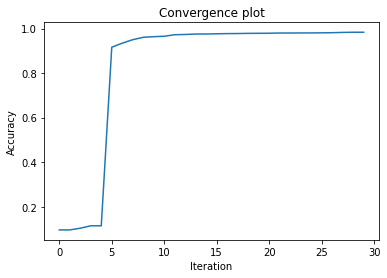

In [20]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [21]:
results.head()

,number,value,datetime_start,datetime_complete,duration,params_activation0,params_activation1,params_activation2,params_filters_0,params_filters_1,...,params_num_conv_layers,params_num_dense_layers,params_optimizer_name,params_strides0,params_strides1,params_strides2,params_units0,params_units1,params_units2,state
0,0,0.973280,2021-05-20 18:21:58.124679,2021-05-20 18:23:44.991946,0 days 00:01:46.867267,tanh,NaN,NaN,16,NaN,...,1,1,Adam,1,NaN,NaN,389,NaN,NaN,COMPLETE
1,1,0.934392,2021-05-20 18:23:45.104026,2021-05-20 18:30:28.707171,0 days 00:06:43.603145,tanh,tanh,tanh,16,64.0,...,3,2,Adam,1,2.0,1.0,353,297.0,NaN,COMPLETE
2,2,0.096032,2021-05-20 18:30:28.783724,2021-05-20 18:46:56.184767,0 days 00:16:27.401043,relu,relu,tanh,64,16.0,...,3,1,RMSprop,1,1.0,1.0,334,NaN,NaN,COMPLETE
3,3,0.103704,2021-05-20 18:46:56.245810,2021-05-20 19:00:32.438469,0 days 00:13:36.192659,tanh,tanh,NaN,64,32.0,...,2,2,RMSprop,1,1.0,NaN,24,441.0,NaN,COMPLETE
4,4,0.976455,2021-05-20 19:00:32.502514,2021-05-20 19:08:10.338109,0 days 00:07:37.835595,relu,relu,NaN,32,16.0,...,2,1,RMSprop,1,1.0,NaN,255,NaN,NaN,COMPLETE


# Evaluate the model

In [22]:
# load best model

model = load_model(path_best_model)

In [23]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 492)               771948    
_________________________________________________________________
dense_34 (Dense)             (None, 12)                5916      
_________________________________________________________________
dense_35 (Dense)             (None, 17)                221       
_________________________________________________________________
dense_36 (Dense)             (None, 10)              

In [24]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 4s 15ms/step - loss: 0.0617 - accuracy: 0.9843


In [25]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06171351298689842
accuracy 0.9842857122421265


## Confusion matrix

In [26]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[419,   0,   0,   0,   0,   0,   1,   0,   2,   0],
       [  0, 469,   0,   0,   0,   0,   1,   2,   1,   0],
       [  2,   3, 402,   0,   0,   0,   1,   1,   0,   0],
       [  0,   0,   1, 420,   0,   2,   0,   2,   1,   0],
       [  1,   2,   0,   0, 422,   0,   3,   1,   0,   0],
       [  0,   0,   0,   2,   0, 374,   3,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0, 412,   0,   0,   0],
       [  0,   1,   4,   2,   0,   0,   0, 462,   0,   0],
       [  0,   2,   0,   1,   0,   1,   2,   0, 378,   0],
       [  4,   2,   0,   2,   8,   0,   0,   1,   1, 376]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

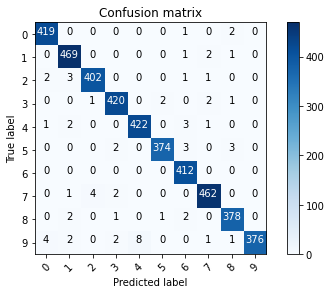

In [27]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.